In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import necessary libraries
import os
import glob
import pandas as pd
import datetime
from datetime import date,timedelta
from datetime import datetime as dt
from dateutil.relativedelta import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, InputLayer, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

!pip install pandas_ta
import pandas_ta as ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=85d185b531e88ef87a8d44cac02b3e2bf08ff0c5eba0a45991e94f1ab23f2b59
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [38]:

path = '/content/drive/My Drive/Colab Notebooks/vn_stock/'
os.chdir(path)
bestModelDir = "./best_models/"
if not os.path.exists(bestModelDir):
  print("True")
  os.makedirs(bestModelDir)

True


In [42]:
goodmse = 0.1


#Data preprocessing

##Company filtering
Choose banks only

In [25]:
import yfinance as yf
import os
import pandas as pd

# List of Vietnamese banks' tickers
tickers_vietnam_banks = ['VCB.VN', 'BID.VN', 'CTG.VN', 'STB.VN', 'ACB.VN', 'MBB.VN', 'TCB.VN', 'SHB.VN', 'VPB.VN', 'ACB.VN', 'TPB.VN', 'VAB.VN', 'VBB.VN', 'BAB.VN', 'HDB.VN']

folder_path = '/content/drive/MyDrive/Colab Notebooks/vn_stock/'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

finName = []
tickerName = []

for ticker in tickers_vietnam_banks:
    # Download stock data from Yahoo Finance
    data = yf.download(ticker, start="2010-01-01", end="2024-12-31")

    # Check if the data has at least 730 days of history
    if len(data) >= 730:
        # Drop the second and third rows (index 1 and 2)
        data = data.reset_index()  # Ensure "Date" is part of the DataFrame
        data = data.drop([1, 2], axis=0)  # Drop the rows at index 1 and 2

        # Rename the columns to match the order
        data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
        data['Date'] = pd.to_datetime(data['Date']).dt.date

        file_path = os.path.join(folder_path, f'{ticker}.csv')
        data.to_csv(file_path, index=False)

        # If data has sufficient history, add to the list
        finName.append(file_path)
        tickerName.append(ticker)

        print(f"Data for {ticker} saved to {file_path}")
    else:
        print(f"Skipping {ticker} due to insufficient data")

print(f"Total valid data files: {len(finName)}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for VCB.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/VCB.VN.csv
Data for BID.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/BID.VN.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for CTG.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/CTG.VN.csv
Skipping STB.VN due to insufficient data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for ACB.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/ACB.VN.csv
Skipping MBB.VN due to insufficient data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for TCB.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/TCB.VN.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data for SHB.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/SHB.VN.csv
Skipping VPB.VN due to insufficient data



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VAB.VN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Data for ACB.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/ACB.VN.csv
Data for TPB.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/TPB.VN.csv


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VBB.VN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BAB.VN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

Skipping VAB.VN due to insufficient data
Skipping VBB.VN due to insufficient data
Skipping BAB.VN due to insufficient data
Data for HDB.VN saved to /content/drive/MyDrive/Colab Notebooks/vn_stock/HDB.VN.csv
Total valid data files: 9


In [12]:
def window_sliding(data, window, prediction_day):
  """Load and split data into training features and labels"""
  X_data, y_data = [], []
  for i in range(len(data) - window- prediction_day):
      X_data.append(data.iloc[i:i + window].to_numpy())
      y_data.append(data.iloc[i + window:i + window + prediction_day].to_numpy())
  return X_data, y_data

In [13]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
def minMaxScaling(X, y):
  X_norm = X.copy()
  y_norm = y.copy()
  for i in range(0, len(X)):
      min_feature = np.min(X[i])
      max_feature = np.max(X[i])
      X_norm[i] = (X[i] - min_feature) / (max_feature - min_feature)
      y_norm[i] = (y[i] - min_feature) / (max_feature - min_feature)
  return X_norm, y_norm

In [14]:
def denormMinMax(X, y):
  # MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
  X_denorm = X.copy()
  y_denorm = y.copy()
  for i in range(0, len(y)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X[i])
    max_feature = np.max(X[i])
    y_denorm[i] = y[i] * (max_feature - min_feature) + min_feature
  return X_denorm, y_denorm

In [15]:
def denorm_training(y, X):
  min_feature = np.min(X)
  max_feature = np.max(X)
  return y * (max_feature - min_feature) + min_feature

In [16]:
def normalize_training(X):
    min_feature = np.min(X)
    max_feature = np.max(X)
    X_norm = (X - min_feature) / (max_feature - min_feature)
    return X_norm

Building LSTM Model

In [18]:
### Create and train the model

def modelLSTM(X_train_norm, y_train_norm, X_test_norm, y_test_norm, feature, pDay):
  ### Create the model
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(X_train_norm.shape[1:])))
  model.add(keras.layers.LSTM(units=128, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(keras.layers.Dense((feature))) #Number of columns in original datas used for training
  model.add(keras.layers.Cropping1D(cropping=(X_train_norm.shape[1] - pDay, 0))) #Getting the output shape as (None, prediction_day, feature)
  model.summary()

  #Training the model with callbacks for saving the best models, learning_rate reduction, and early stopping
  from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
  mc = ModelCheckpoint(filepath="epoch-{epoch:02d}.keras", # Path to save the model
                                        monitor='val_mse', # Metric to evaluate the model performance when looking for a better model.
                                        mode='min', # mode='auto'/'max'/'min': the monitor should be max/min to be better.
                                                    # In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' (f-score) and are set to min for the rest of the quantities.
                                        verbose=0, # Inform every time a better model is found and saved.
                                        save_best_only=True) # Only save the model if the current training epoch is the best. 'False' means save models of all training epochs
  r_reduced = ReduceLROnPlateau(monitor='val_mse', mode='min', verbose = 0,
                                  factor = 0.2, patience = 5, min_lr = 0.000001)
  es = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=10)
  model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0001), loss='mse', metrics=['mse'], run_eagerly=True)
  model.fit(X_train_norm, y_train_norm, validation_data=(X_test_norm, y_test_norm), epochs=10,
            batch_size=4096, callbacks = [mc, r_reduced, es], verbose=1)
  # model.summary()
  return model


##Class for cross-validation
This class works similarly to the function TimeSeriessplit(), except that it allows you to specify how much data for each training and validation set you want

In [19]:

class TimeSeriesCV(object):


    def __init__(self, train_period, test_period, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq


    def split(self, data, gap=0):

        listTrain = []
        listTest = []

        start_train = 0
        end_train = start_train + self.train_period
        start_test = end_train + gap
        end_test = start_test + self.test_period

        while end_test < data.shape[0]:
            # train indices:
            trainIndex = []
            testIndex = []
            for i in range(start_train, end_train):
              trainIndex.append(i)
            for i in range (start_test, end_test):
              testIndex.append(i)

            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(trainIndex), ", # test records", len(testIndex))

            listTrain.append(trainIndex)
            listTest.append(testIndex)

            # update dates:
            start_train = start_train
            end_train += self.train_period
            start_test = end_train + gap
            end_test = start_test + self.test_period

        end_test = data.shape[0]
        start_test = end_test - self.test_period
        end_train = start_test
        trainIndex = []
        testIndex = []
        for i in range(start_train, end_train):
          trainIndex.append(i)
        for i in range (start_test, end_test):
          testIndex.append(i)
        listTrain.append(trainIndex)
        listTest.append(testIndex)
        print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(trainIndex), ", # test records", len(testIndex))

        index_output = [(train,test) for train,test in zip(listTrain, listTest)]
        self.n_splits = len(index_output)

        return index_output


    def get_n_splits(self):
        return self.n_splits

#Model training

##Training the models using cross-validation technique to choose the best models

In [40]:
#Choose the features for the models
columns = ["Open", "High", "Low", "Close"]
#Choose the window_size and prediction day
window_size = 90
prediction_day = 7
#Array to save the best companies with best models
goodCom = []
goodComPath = []
allMse = []
#Cross-validation for each company to pick the best ones with the best models
for name in finName:
  #Pre-processing the data
  data_for_modeling=pd.read_csv(name)[columns]
  X_data, y_data = window_sliding(data_for_modeling, window_size, prediction_day)
  X_data, y_data = np.array(X_data), np.array(y_data)
  X_train, X_test, y_train, y_test= train_test_split(X_data, y_data, test_size=0.2, shuffle=False, random_state=0)
  # y_train, y_test= train_test_split(y_data, test_size=0.2, shuffle=False, random_state=0)
  X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
  X_test_norm, y_test_norm = minMaxScaling(X_test, y_test)
  print(X_train.shape, y_train.shape)
  print("Shape of test set: ", X_test.shape, y_test.shape)
  #Array to save the models and mse values
  ensemble = []
  mses = []
  #Create TimeBasedCV object with specifeid train and test periods. Frequency = 'day', although the parameters is useless for this case
  tscv = TimeSeriesCV(train_period=365,
                    test_period=180,
                    freq='days')
  #Cross-validation for the folds by TimeSeriesCV object
  for train_index, test_index in tscv.split(X_train):
    #Picking up the data
      X_train_VC   = X_train[train_index]
      y_train_VC = y_train[train_index]

      X_val_VC    = X_train[test_index]
      y_val_VC  = y_train[test_index]

      #Normalize the data features and labels
      X_train_norm, y_train_norm = minMaxScaling(X_train_VC, y_train_VC)
      X_val_norm, y_val_norm = minMaxScaling(X_val_VC, y_val_VC)

      #Call the model to train on the data
      model1 = modelLSTM(X_train_norm, y_train_norm, X_val_norm, y_val_norm, len(columns), prediction_day)
      #Append the model for later evaluation
      ensemble.append(model1)
      loss, mse = model1.evaluate(X_test_norm, y_test_norm, verbose=0)
      mses.append(mse)

  overall_mse = np.average(mses)
  allMse.append(overall_mse)
  print("Overall MSE: ", overall_mse)
# Pick the models with mse lower than the threshold
  if overall_mse < goodmse:
     goodCom.append(tickerName[finName.index(name)])
     goodComPath.append(name)
     ensemble[np.argmin(mses)].save(filepath=bestModelDir + tickerName[finName.index(name)] + '.keras', include_optimizer=False)

     data_for_modeling["ticker"] = tickerName[finName.index(name)]

(2889, 90, 4) (2889, 7, 4)
Shape of test set:  (723, 90, 4) (723, 7, 4)
Train period: 0 - 365 , Test period 365 - 545 # train records 365 , # test records 180
Train period: 0 - 730 , Test period 730 - 910 # train records 730 , # test records 180
Train period: 0 - 1095 , Test period 1095 - 1275 # train records 1095 , # test records 180
Train period: 0 - 1460 , Test period 1460 - 1640 # train records 1460 , # test records 180
Train period: 0 - 1825 , Test period 1825 - 2005 # train records 1825 , # test records 180
Train period: 0 - 2190 , Test period 2190 - 2370 # train records 2190 , # test records 180
Train period: 0 - 2555 , Test period 2555 - 2735 # train records 2555 , # test records 180
Train period: 0 - 2709 , Test period 2709 - 2889 # train records 2709 , # test records 180


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_72 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.1558 - mse: 0.1558 - val_loss: 0.3388 - val_mse: 0.3388 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.1524 - mse: 0.1524 - val_loss: 0.3300 - val_mse: 0.3300 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1464 - mse: 0.1464 - val_loss: 0.3212 - val_mse: 0.3212 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 0.1444 - mse: 0.1444 - val_loss: 0.3126 - val_mse: 0.3126 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.1381 - mse: 0.1381 - val_loss: 0.3041 - val_mse: 0.3041 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.1349 - mse: 0.1349 - val_loss: 0.2958 - val_mse: 0.2958 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1309 - mse: 0.1309 - val_loss: 0.2876 - val_mse: 0.2876 - learning_rate: 1.0

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_73 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_73 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.2812 - mse: 0.2812 - val_loss: 0.2634 - val_mse: 0.2634 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.2757 - mse: 0.2757 - val_loss: 0.2571 - val_mse: 0.2571 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.2694 - mse: 0.2694 - val_loss: 0.2508 - val_mse: 0.2508 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.2638 - mse: 0.2638 - val_loss: 0.2447 - val_mse: 0.2447 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.2590 - mse: 0.2590 - val_loss: 0.2387 - val_mse: 0.2387 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.2532 - mse: 0.2532 - val_loss: 0.2327 - val_mse: 0.2327 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2469 - mse: 0.2469 - val_loss: 0.2269 - val_mse: 0.2269 - learning_rate: 1.0

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_74 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_74 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.3106 - mse: 0.3106 - val_loss: 0.6789 - val_mse: 0.6789 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.3032 - mse: 0.3032 - val_loss: 0.6640 - val_mse: 0.6640 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2953 - mse: 0.2953 - val_loss: 0.6494 - val_mse: 0.6494 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2874 - mse: 0.2874 - val_loss: 0.6350 - val_mse: 0.6350 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.2807 - mse: 0.2807 - val_loss: 0.6208 - val_mse: 0.6208 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.2742 - mse: 0.2742 - val_loss: 0.6068 - val_mse: 0.6068 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.2663 - mse: 0.2663 - val_loss: 0.5931 - val_mse: 0.5931 - learning_rate: 1.0

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_75 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.3523 - mse: 0.3523 - val_loss: 0.4267 - val_mse: 0.4267 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.3453 - mse: 0.3453 - val_loss: 0.4170 - val_mse: 0.4170 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.3367 - mse: 0.3367 - val_loss: 0.4073 - val_mse: 0.4073 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.3290 - mse: 0.3290 - val_loss: 0.3978 - val_mse: 0.3978 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3199 - mse: 0.3199 - val_loss: 0.3885 - val_mse: 0.3885 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.3138 - mse: 0.3138 - val_loss: 0.3792 - val_mse: 0.3792 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.3051 - mse: 0.3051 - val_loss: 0.3701 - val_mse: 0.3701 - learning_rate: 1.0

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_76 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_76 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.5030 - mse: 0.5030 - val_loss: 0.9634 - val_mse: 0.9634 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - loss: 0.4926 - mse: 0.4926 - val_loss: 0.9469 - val_mse: 0.9469 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.4832 - mse: 0.4832 - val_loss: 0.9307 - val_mse: 0.9307 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.4727 - mse: 0.4727 - val_loss: 0.9149 - val_mse: 0.9149 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.4646 - mse: 0.4646 - val_loss: 0.8994 - val_mse: 0.8994 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.4563 - mse: 0.4563 - val_loss: 0.8841 - val_mse: 0.8841 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.4477 - mse: 0.4477 - val_loss: 0.8692 - val_mse: 0.8692 - learning_rate: 1.0

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_77 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_77 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.5284 - mse: 0.5284 - val_loss: 1.1248 - val_mse: 1.1248 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.5179 - mse: 0.5179 - val_loss: 1.1018 - val_mse: 1.1018 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.5071 - mse: 0.5071 - val_loss: 1.0791 - val_mse: 1.0791 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.4964 - mse: 0.4964 - val_loss: 1.0567 - val_mse: 1.0567 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.4866 - mse: 0.4866 - val_loss: 1.0347 - val_mse: 1.0347 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.4767 - mse: 0.4767 - val_loss: 1.0129 - val_mse: 1.0129 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.4667 - mse: 0.4667 - val_loss: 0.9915 - val_mse: 0.9915 - learning_rate: 1.0

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_78 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.4176 - mse: 0.4176 - val_loss: 0.5445 - val_mse: 0.5445 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.4076 - mse: 0.4076 - val_loss: 0.5310 - val_mse: 0.5310 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3984 - mse: 0.3984 - val_loss: 0.5178 - val_mse: 0.5178 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3883 - mse: 0.3883 - val_loss: 0.5047 - val_mse: 0.5047 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3801 - mse: 0.3801 - val_loss: 0.4917 - val_mse: 0.4917 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.3711 - mse: 0.3711 - val_loss: 0.4790 - val_mse: 0.4790 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3618 - mse: 0.3618 - val_loss: 0.4664 - val_mse: 0.4664 - learning_rate: 1.0

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_79 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_79 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.3832 - mse: 0.3832 - val_loss: 0.2420 - val_mse: 0.2420 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.3729 - mse: 0.3729 - val_loss: 0.2363 - val_mse: 0.2363 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.3649 - mse: 0.3649 - val_loss: 0.2306 - val_mse: 0.2306 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.3555 - mse: 0.3555 - val_loss: 0.2251 - val_mse: 0.2251 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3457 - mse: 0.3457 - val_loss: 0.2197 - val_mse: 0.2197 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.3388 - mse: 0.3388 - val_loss: 0.2144 - val_mse: 0.2144 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.3296 - mse: 0.3296 - val_loss: 0.2091 - val_mse: 0.2091 - learning_rate: 1.0

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_80 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.4436 - mse: 0.4436 - val_loss: 0.1865 - val_mse: 0.1865 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - loss: 0.4383 - mse: 0.4383 - val_loss: 0.1804 - val_mse: 0.1804 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.4243 - mse: 0.4243 - val_loss: 0.1744 - val_mse: 0.1744 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.4132 - mse: 0.4132 - val_loss: 0.1685 - val_mse: 0.1685 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.4043 - mse: 0.4043 - val_loss: 0.1627 - val_mse: 0.1627 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.3947 - mse: 0.3947 - val_loss: 0.1570 - val_mse: 0.1570 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.3830 - mse: 0.3830 - val_loss: 0.1513 - val_mse: 0.1513 - learning_rate: 1.0

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_81 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.3452 - mse: 0.3452 - val_loss: 0.6781 - val_mse: 0.6781 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.3368 - mse: 0.3368 - val_loss: 0.6631 - val_mse: 0.6631 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.3286 - mse: 0.3286 - val_loss: 0.6482 - val_mse: 0.6482 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.3213 - mse: 0.3213 - val_loss: 0.6336 - val_mse: 0.6336 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.3132 - mse: 0.3132 - val_loss: 0.6192 - val_mse: 0.6192 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.3020 - mse: 0.3020 - val_loss: 0.6049 - val_mse: 0.6049 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.2961 - mse: 0.2961 - val_loss: 0.5909 - val_mse: 0.5909 - learning_rate: 1.0

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_82 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_82 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.4401 - mse: 0.4401 - val_loss: 0.3500 - val_mse: 0.3500 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.4295 - mse: 0.4295 - val_loss: 0.3412 - val_mse: 0.3412 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.4205 - mse: 0.4205 - val_loss: 0.3325 - val_mse: 0.3325 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.4111 - mse: 0.4111 - val_loss: 0.3239 - val_mse: 0.3239 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.4010 - mse: 0.4010 - val_loss: 0.3154 - val_mse: 0.3154 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.3905 - mse: 0.3905 - val_loss: 0.3069 - val_mse: 0.3069 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3830 - mse: 0.3830 - val_loss: 0.2986 - val_mse: 0.2986 - learning_rate: 1.0

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_83 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_83 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.4825 - mse: 0.4825 - val_loss: 0.4683 - val_mse: 0.4683 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.4718 - mse: 0.4718 - val_loss: 0.4575 - val_mse: 0.4575 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.4608 - mse: 0.4608 - val_loss: 0.4468 - val_mse: 0.4468 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.4518 - mse: 0.4518 - val_loss: 0.4363 - val_mse: 0.4363 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.4417 - mse: 0.4417 - val_loss: 0.4259 - val_mse: 0.4259 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.4301 - mse: 0.4301 - val_loss: 0.4157 - val_mse: 0.4157 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.4218 - mse: 0.4218 - val_loss: 0.4055 - val_mse: 0.4055 - learning_rate: 1.0

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_84 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.4277 - mse: 0.4277 - val_loss: 0.4012 - val_mse: 0.4012 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - loss: 0.4175 - mse: 0.4175 - val_loss: 0.3925 - val_mse: 0.3925 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.4094 - mse: 0.4094 - val_loss: 0.3839 - val_mse: 0.3839 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.3980 - mse: 0.3980 - val_loss: 0.3754 - val_mse: 0.3754 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3899 - mse: 0.3899 - val_loss: 0.3671 - val_mse: 0.3671 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3799 - mse: 0.3799 - val_loss: 0.3589 - val_mse: 0.3589 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.3711 - mse: 0.3711 - val_loss: 0.3508 - val_mse: 0.3508 - learning_rate: 1.0

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_85 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_85 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.3892 - mse: 0.3892 - val_loss: 0.2195 - val_mse: 0.2195 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.3810 - mse: 0.3810 - val_loss: 0.2130 - val_mse: 0.2130 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.3739 - mse: 0.3739 - val_loss: 0.2066 - val_mse: 0.2066 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.3650 - mse: 0.3650 - val_loss: 0.2003 - val_mse: 0.2003 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.3556 - mse: 0.3556 - val_loss: 0.1941 - val_mse: 0.1941 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.3482 - mse: 0.3482 - val_loss: 0.1881 - val_mse: 0.1881 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.3393 - mse: 0.3393 - val_loss: 0.1821 - val_mse: 0.1821 - learning_rate: 1.0

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_86 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_86 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.2263 - mse: 0.2263 - val_loss: 0.3841 - val_mse: 0.3841 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2204 - mse: 0.2204 - val_loss: 0.3743 - val_mse: 0.3743 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.2148 - mse: 0.2148 - val_loss: 0.3646 - val_mse: 0.3646 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2099 - mse: 0.2099 - val_loss: 0.3551 - val_mse: 0.3551 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2055 - mse: 0.2055 - val_loss: 0.3457 - val_mse: 0.3457 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2016 - mse: 0.2016 - val_loss: 0.3365 - val_mse: 0.3365 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1954 - mse: 0.1954 - val_loss: 0.3274 - val_mse: 0.3274 - learning_rate: 1.0

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_87 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_87 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.3030 - mse: 0.3030 - val_loss: 0.1078 - val_mse: 0.1078 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.2977 - mse: 0.2977 - val_loss: 0.1051 - val_mse: 0.1051 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.2898 - mse: 0.2898 - val_loss: 0.1025 - val_mse: 0.1025 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.2827 - mse: 0.2827 - val_loss: 0.1000 - val_mse: 0.1000 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2771 - mse: 0.2771 - val_loss: 0.0975 - val_mse: 0.0975 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.2709 - mse: 0.2709 - val_loss: 0.0951 - val_mse: 0.0951 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2654 - mse: 0.2654 - val_loss: 0.0928 - val_mse: 0.0928 - learning_rate: 1.0

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_88 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.2069 - mse: 0.2069 - val_loss: 0.4411 - val_mse: 0.4411 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 0.2004 - mse: 0.2004 - val_loss: 0.4317 - val_mse: 0.4317 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1966 - mse: 0.1966 - val_loss: 0.4224 - val_mse: 0.4224 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1908 - mse: 0.1908 - val_loss: 0.4132 - val_mse: 0.4132 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1863 - mse: 0.1863 - val_loss: 0.4041 - val_mse: 0.4041 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.1809 - mse: 0.1809 - val_loss: 0.3951 - val_mse: 0.3951 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.1772 - mse: 0.1772 - val_loss: 0.3862 - val_mse: 0.3862 - learning_rate: 1.0

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_89 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_89 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.2240 - mse: 0.2240 - val_loss: 0.1414 - val_mse: 0.1414 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.2172 - mse: 0.2172 - val_loss: 0.1369 - val_mse: 0.1369 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.2110 - mse: 0.2110 - val_loss: 0.1326 - val_mse: 0.1326 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.2038 - mse: 0.2038 - val_loss: 0.1283 - val_mse: 0.1283 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.1972 - mse: 0.1972 - val_loss: 0.1241 - val_mse: 0.1241 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.1914 - mse: 0.1914 - val_loss: 0.1200 - val_mse: 0.1200 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.1856 - mse: 0.1856 - val_loss: 0.1160 - val_mse: 0.1160 - learning_rate: 1.0

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_90 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.3038 - mse: 0.3038 - val_loss: 0.6149 - val_mse: 0.6149 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.2966 - mse: 0.2966 - val_loss: 0.6038 - val_mse: 0.6038 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.2919 - mse: 0.2919 - val_loss: 0.5929 - val_mse: 0.5929 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2852 - mse: 0.2852 - val_loss: 0.5821 - val_mse: 0.5821 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2798 - mse: 0.2798 - val_loss: 0.5714 - val_mse: 0.5714 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2747 - mse: 0.2747 - val_loss: 0.5608 - val_mse: 0.5608 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2683 - mse: 0.2683 - val_loss: 0.5503 - val_mse: 0.5503 - learning_rate: 1.0

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_91 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_91 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.3111 - mse: 0.3111 - val_loss: 0.3153 - val_mse: 0.3153 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.3049 - mse: 0.3049 - val_loss: 0.3075 - val_mse: 0.3075 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.2962 - mse: 0.2962 - val_loss: 0.2998 - val_mse: 0.2998 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.2909 - mse: 0.2909 - val_loss: 0.2921 - val_mse: 0.2921 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2851 - mse: 0.2851 - val_loss: 0.2846 - val_mse: 0.2846 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - loss: 0.2793 - mse: 0.2793 - val_loss: 0.2771 - val_mse: 0.2771 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.2731 - mse: 0.2731 - val_loss: 0.2697 - val_mse: 0.2697 - learning_rate: 1.0

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_92 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_92 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.3067 - mse: 0.3067 - val_loss: 0.8232 - val_mse: 0.8232 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.2990 - mse: 0.2990 - val_loss: 0.8014 - val_mse: 0.8014 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.2911 - mse: 0.2911 - val_loss: 0.7797 - val_mse: 0.7798 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.2845 - mse: 0.2845 - val_loss: 0.7583 - val_mse: 0.7583 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.2762 - mse: 0.2762 - val_loss: 0.7370 - val_mse: 0.7370 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.2687 - mse: 0.2687 - val_loss: 0.7159 - val_mse: 0.7159 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.2617 - mse: 0.2617 - val_loss: 0.6949 - val_mse: 0.6949 - learning_rate: 1.0

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_93 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_93 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.3604 - mse: 0.3604 - val_loss: 0.4068 - val_mse: 0.4068 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.3528 - mse: 0.3528 - val_loss: 0.3975 - val_mse: 0.3975 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.3454 - mse: 0.3454 - val_loss: 0.3884 - val_mse: 0.3884 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.3370 - mse: 0.3370 - val_loss: 0.3793 - val_mse: 0.3793 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.3309 - mse: 0.3309 - val_loss: 0.3704 - val_mse: 0.3704 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.3240 - mse: 0.3240 - val_loss: 0.3617 - val_mse: 0.3617 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.3165 - mse: 0.3165 - val_loss: 0.3530 - val_mse: 0.3530 - learning_rate: 1.0

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_94 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_94 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0926 - mse: 0.0926 - val_loss: 0.2679 - val_mse: 0.2679 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0900 - mse: 0.0900 - val_loss: 0.2605 - val_mse: 0.2605 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.2532 - val_mse: 0.2532 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.0840 - mse: 0.0840 - val_loss: 0.2461 - val_mse: 0.2461 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.2390 - val_mse: 0.2390 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.2320 - val_mse: 0.2320 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.0772 - mse: 0.0772 - val_loss: 0.2252 - val_mse: 0.2252 - learning_rate: 1.0

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_95 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_95 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.1665 - mse: 0.1665 - val_loss: 0.2486 - val_mse: 0.2486 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 0.1629 - mse: 0.1629 - val_loss: 0.2417 - val_mse: 0.2417 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.1592 - mse: 0.1592 - val_loss: 0.2349 - val_mse: 0.2349 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.1563 - mse: 0.1563 - val_loss: 0.2281 - val_mse: 0.2281 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.1533 - mse: 0.1533 - val_loss: 0.2215 - val_mse: 0.2215 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1491 - mse: 0.1491 - val_loss: 0.2150 - val_mse: 0.2150 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 0.1455 - mse: 0.1455 - val_loss: 0.2085 - val_mse: 0.2085 - learning_rate: 1.0

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_96 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_96 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.2278 - mse: 0.2278 - val_loss: 0.4998 - val_mse: 0.4998 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2219 - mse: 0.2219 - val_loss: 0.4898 - val_mse: 0.4898 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2170 - mse: 0.2170 - val_loss: 0.4798 - val_mse: 0.4798 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.2107 - mse: 0.2107 - val_loss: 0.4700 - val_mse: 0.4700 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.2057 - mse: 0.2057 - val_loss: 0.4603 - val_mse: 0.4603 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.2003 - mse: 0.2003 - val_loss: 0.4507 - val_mse: 0.4507 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.1951 - mse: 0.1951 - val_loss: 0.4412 - val_mse: 0.4412 - learning_rate: 1.0

Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_97 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_97 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_97 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.2787 - mse: 0.2787 - val_loss: 0.2582 - val_mse: 0.2582 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.2740 - mse: 0.2740 - val_loss: 0.2523 - val_mse: 0.2523 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.2674 - mse: 0.2674 - val_loss: 0.2465 - val_mse: 0.2465 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.2605 - mse: 0.2605 - val_loss: 0.2408 - val_mse: 0.2408 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2553 - mse: 0.2553 - val_loss: 0.2352 - val_mse: 0.2352 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2491 - mse: 0.2491 - val_loss: 0.2298 - val_mse: 0.2298 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.2437 - mse: 0.2437 - val_loss: 0.2244 - val_mse: 0.2244 - learning_rate: 1.0

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_98 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_98 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_98 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.3592 - mse: 0.3592 - val_loss: 0.9086 - val_mse: 0.9086 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.3485 - mse: 0.3485 - val_loss: 0.8854 - val_mse: 0.8854 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.3398 - mse: 0.3398 - val_loss: 0.8627 - val_mse: 0.8627 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 0.3309 - mse: 0.3309 - val_loss: 0.8405 - val_mse: 0.8405 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.3237 - mse: 0.3237 - val_loss: 0.8186 - val_mse: 0.8186 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - loss: 0.3145 - mse: 0.3145 - val_loss: 0.7972 - val_mse: 0.7972 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.3076 - mse: 0.3076 - val_loss: 0.7763 - val_mse: 0.7763 - learning_rate: 1.0

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_99 (LSTM)                       │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_99 (Dropout)                 │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_99 (Cropping1D)           │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3561 - mse: 0.3561 - val_loss: 0.3170 - val_mse: 0.3170 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.3480 - mse: 0.3480 - val_loss: 0.3078 - val_mse: 0.3078 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.3389 - mse: 0.3389 - val_loss: 0.2989 - val_mse: 0.2989 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.3311 - mse: 0.3311 - val_loss: 0.2901 - val_mse: 0.2901 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.3229 - mse: 0.3229 - val_loss: 0.2815 - val_mse: 0.2815 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.3141 - mse: 0.3141 - val_loss: 0.2730 - val_mse: 0.2730 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.3060 - mse: 0.3060 - val_loss: 0.2647 - val_mse: 0.2647 - learning_rate: 1.0

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_100 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_100 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_100 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.3599 - mse: 0.3599 - val_loss: 0.9361 - val_mse: 0.9361 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.3519 - mse: 0.3519 - val_loss: 0.9154 - val_mse: 0.9154 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.3445 - mse: 0.3445 - val_loss: 0.8950 - val_mse: 0.8950 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.3368 - mse: 0.3368 - val_loss: 0.8748 - val_mse: 0.8748 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.3290 - mse: 0.3290 - val_loss: 0.8549 - val_mse: 0.8549 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.3222 - mse: 0.3222 - val_loss: 0.8351 - val_mse: 0.8351 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.3152 - mse: 0.3152 - val_loss: 0.8156 - val_mse: 0.8156 - learning_rate: 1.0

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_101 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_101 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.4059 - mse: 0.4059 - val_loss: 0.5125 - val_mse: 0.5125 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.3965 - mse: 0.3965 - val_loss: 0.4998 - val_mse: 0.4998 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.3872 - mse: 0.3872 - val_loss: 0.4872 - val_mse: 0.4872 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.3785 - mse: 0.3785 - val_loss: 0.4749 - val_mse: 0.4749 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3706 - mse: 0.3706 - val_loss: 0.4627 - val_mse: 0.4627 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3613 - mse: 0.3613 - val_loss: 0.4507 - val_mse: 0.4507 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.3530 - mse: 0.3530 - val_loss: 0.4389 - val_mse: 0.4389 - learning_rate: 1.0

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_102 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_102 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.2441 - mse: 0.2441 - val_loss: 0.5576 - val_mse: 0.5576 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.2368 - mse: 0.2368 - val_loss: 0.5456 - val_mse: 0.5456 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.2314 - mse: 0.2314 - val_loss: 0.5337 - val_mse: 0.5337 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.2267 - mse: 0.2267 - val_loss: 0.5220 - val_mse: 0.5220 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.2206 - mse: 0.2206 - val_loss: 0.5105 - val_mse: 0.5105 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.2161 - mse: 0.2161 - val_loss: 0.4992 - val_mse: 0.4992 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.2112 - mse: 0.2112 - val_loss: 0.4880 - val_mse: 0.4880 - learning_rate: 1.0

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_103 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_103 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.4265 - mse: 0.4265 - val_loss: 0.1235 - val_mse: 0.1235 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.4121 - mse: 0.4121 - val_loss: 0.1200 - val_mse: 0.1200 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.4014 - mse: 0.4014 - val_loss: 0.1166 - val_mse: 0.1166 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.3910 - mse: 0.3910 - val_loss: 0.1133 - val_mse: 0.1133 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.3805 - mse: 0.3805 - val_loss: 0.1101 - val_mse: 0.1101 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.3698 - mse: 0.3698 - val_loss: 0.1070 - val_mse: 0.1070 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.3575 - mse: 0.3575 - val_loss: 0.1039 - val_mse: 0.1039 - learning_rate: 1.0

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_104 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_104 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.3731 - mse: 0.3731 - val_loss: 0.5778 - val_mse: 0.5778 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.3650 - mse: 0.3650 - val_loss: 0.5627 - val_mse: 0.5627 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.3533 - mse: 0.3533 - val_loss: 0.5478 - val_mse: 0.5478 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3455 - mse: 0.3455 - val_loss: 0.5331 - val_mse: 0.5331 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3378 - mse: 0.3378 - val_loss: 0.5187 - val_mse: 0.5187 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.3289 - mse: 0.3289 - val_loss: 0.5045 - val_mse: 0.5045 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.3203 - mse: 0.3203 - val_loss: 0.4906 - val_mse: 0.4906 - learning_rate: 1.0

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_105 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_105 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_105 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.0596 - mse: 0.0596 - val_loss: 0.3894 - val_mse: 0.3894 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 0.0587 - mse: 0.0587 - val_loss: 0.3807 - val_mse: 0.3807 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0572 - mse: 0.0572 - val_loss: 0.3722 - val_mse: 0.3722 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0551 - mse: 0.0551 - val_loss: 0.3638 - val_mse: 0.3638 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.3556 - val_mse: 0.3556 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.3475 - val_mse: 0.3475 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.3396 - val_mse: 0.3396 - learning_rate: 1.0

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_106 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_106 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_106 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1580 - mse: 0.1580 - val_loss: 0.2660 - val_mse: 0.2660 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.1553 - mse: 0.1553 - val_loss: 0.2579 - val_mse: 0.2579 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.1505 - mse: 0.1505 - val_loss: 0.2500 - val_mse: 0.2500 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1476 - mse: 0.1476 - val_loss: 0.2422 - val_mse: 0.2422 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.1443 - mse: 0.1443 - val_loss: 0.2347 - val_mse: 0.2347 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - loss: 0.1404 - mse: 0.1404 - val_loss: 0.2272 - val_mse: 0.2272 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.1367 - mse: 0.1367 - val_loss: 0.2200 - val_mse: 0.2200 - learning_rate: 1.0

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_107 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_107 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_107 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.3071 - mse: 0.3071 - val_loss: 0.2576 - val_mse: 0.2576 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2988 - mse: 0.2988 - val_loss: 0.2499 - val_mse: 0.2499 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.2916 - mse: 0.2916 - val_loss: 0.2424 - val_mse: 0.2424 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.2845 - mse: 0.2845 - val_loss: 0.2350 - val_mse: 0.2350 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2278 - val_mse: 0.2278 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.2698 - mse: 0.2698 - val_loss: 0.2207 - val_mse: 0.2207 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2626 - mse: 0.2626 - val_loss: 0.2138 - val_mse: 0.2138 - learning_rate: 1.0

Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_108 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_108 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_108 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.2763 - mse: 0.2763 - val_loss: 0.1616 - val_mse: 0.1616 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.2691 - mse: 0.2691 - val_loss: 0.1563 - val_mse: 0.1563 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2610 - mse: 0.2610 - val_loss: 0.1511 - val_mse: 0.1511 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2542 - mse: 0.2542 - val_loss: 0.1460 - val_mse: 0.1460 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2458 - mse: 0.2458 - val_loss: 0.1411 - val_mse: 0.1411 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.2392 - mse: 0.2392 - val_loss: 0.1363 - val_mse: 0.1363 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.2316 - mse: 0.2316 - val_loss: 0.1315 - val_mse: 0.1315 - learning_rate: 1.0

Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_109 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_109 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_109 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.2390 - mse: 0.2390 - val_loss: 0.5081 - val_mse: 0.5081 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.2329 - mse: 0.2329 - val_loss: 0.4927 - val_mse: 0.4927 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.2258 - mse: 0.2258 - val_loss: 0.4775 - val_mse: 0.4775 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.2177 - mse: 0.2177 - val_loss: 0.4626 - val_mse: 0.4626 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.2113 - mse: 0.2113 - val_loss: 0.4479 - val_mse: 0.4479 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.2039 - mse: 0.2039 - val_loss: 0.4335 - val_mse: 0.4335 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - loss: 0.1986 - mse: 0.1986 - val_loss: 0.4192 - val_mse: 0.4192 - learning_rate: 1.0

Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_110 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_110 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_110 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.2892 - mse: 0.2892 - val_loss: 0.1673 - val_mse: 0.1673 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.2832 - mse: 0.2832 - val_loss: 0.1627 - val_mse: 0.1627 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.2761 - mse: 0.2761 - val_loss: 0.1583 - val_mse: 0.1583 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.2696 - mse: 0.2696 - val_loss: 0.1538 - val_mse: 0.1538 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.2633 - mse: 0.2633 - val_loss: 0.1495 - val_mse: 0.1495 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.2575 - mse: 0.2575 - val_loss: 0.1452 - val_mse: 0.1452 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.2514 - mse: 0.2514 - val_loss: 0.1410 - val_mse: 0.1410 - learning_rate: 1.0

Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_111 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_111 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.2938 - mse: 0.2938 - val_loss: 0.6066 - val_mse: 0.6066 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.2862 - mse: 0.2862 - val_loss: 0.5910 - val_mse: 0.5910 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.2788 - mse: 0.2788 - val_loss: 0.5757 - val_mse: 0.5757 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.2709 - mse: 0.2709 - val_loss: 0.5608 - val_mse: 0.5608 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.2642 - mse: 0.2642 - val_loss: 0.5462 - val_mse: 0.5462 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.2576 - mse: 0.2576 - val_loss: 0.5319 - val_mse: 0.5319 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.2508 - mse: 0.2508 - val_loss: 0.5179 - val_mse: 0.5179 - learning_rate: 1.0

Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_112 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_112 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_112 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.2902 - mse: 0.2902 - val_loss: 0.3936 - val_mse: 0.3936 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.2819 - mse: 0.2819 - val_loss: 0.3820 - val_mse: 0.3820 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.2749 - mse: 0.2749 - val_loss: 0.3706 - val_mse: 0.3706 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.2670 - mse: 0.2670 - val_loss: 0.3594 - val_mse: 0.3594 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2594 - mse: 0.2594 - val_loss: 0.3484 - val_mse: 0.3484 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.2526 - mse: 0.2526 - val_loss: 0.3375 - val_mse: 0.3375 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2456 - mse: 0.2456 - val_loss: 0.3268 - val_mse: 0.3268 - learning_rate: 1.0

Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_113 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_113 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_113 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.1245 - mse: 0.1245 - val_loss: 0.3478 - val_mse: 0.3478 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.1209 - mse: 0.1209 - val_loss: 0.3403 - val_mse: 0.3403 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.1182 - mse: 0.1182 - val_loss: 0.3328 - val_mse: 0.3328 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1153 - mse: 0.1153 - val_loss: 0.3255 - val_mse: 0.3255 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.1123 - mse: 0.1123 - val_loss: 0.3182 - val_mse: 0.3182 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1087 - mse: 0.1087 - val_loss: 0.3110 - val_mse: 0.3110 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1070 - mse: 0.1070 - val_loss: 0.3039 - val_mse: 0.3039 - learning_rate: 1.0

Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_114 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_114 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_114 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.2060 - mse: 0.2060 - val_loss: 0.3179 - val_mse: 0.3179 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.1998 - mse: 0.1998 - val_loss: 0.3077 - val_mse: 0.3077 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1942 - mse: 0.1942 - val_loss: 0.2977 - val_mse: 0.2977 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1890 - mse: 0.1890 - val_loss: 0.2879 - val_mse: 0.2879 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.1842 - mse: 0.1842 - val_loss: 0.2783 - val_mse: 0.2783 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1796 - mse: 0.1796 - val_loss: 0.2689 - val_mse: 0.2689 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.1739 - mse: 0.1739 - val_loss: 0.2596 - val_mse: 0.2596 - learning_rate: 1.0

Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_115 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_115 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_115 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.2676 - mse: 0.2676 - val_loss: 0.5680 - val_mse: 0.5680 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.2608 - mse: 0.2608 - val_loss: 0.5564 - val_mse: 0.5564 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2529 - mse: 0.2529 - val_loss: 0.5450 - val_mse: 0.5450 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.2469 - mse: 0.2469 - val_loss: 0.5337 - val_mse: 0.5337 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2404 - mse: 0.2404 - val_loss: 0.5226 - val_mse: 0.5226 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.2333 - mse: 0.2333 - val_loss: 0.5116 - val_mse: 0.5116 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.2281 - mse: 0.2281 - val_loss: 0.5007 - val_mse: 0.5007 - learning_rate: 1.0

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_116 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_116 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_116 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.2720 - mse: 0.2720 - val_loss: 0.2550 - val_mse: 0.2550 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.2674 - mse: 0.2674 - val_loss: 0.2497 - val_mse: 0.2497 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2608 - mse: 0.2608 - val_loss: 0.2445 - val_mse: 0.2445 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.2557 - mse: 0.2557 - val_loss: 0.2394 - val_mse: 0.2394 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.2511 - mse: 0.2511 - val_loss: 0.2344 - val_mse: 0.2344 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.2295 - val_mse: 0.2295 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.2411 - mse: 0.2411 - val_loss: 0.2247 - val_mse: 0.2247 - learning_rate: 1.0

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_117 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_117 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_117 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.3298 - mse: 0.3298 - val_loss: 0.8408 - val_mse: 0.8408 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - loss: 0.3229 - mse: 0.3229 - val_loss: 0.8219 - val_mse: 0.8219 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.3148 - mse: 0.3148 - val_loss: 0.8032 - val_mse: 0.8032 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - loss: 0.3077 - mse: 0.3077 - val_loss: 0.7848 - val_mse: 0.7848 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.3005 - mse: 0.3005 - val_loss: 0.7665 - val_mse: 0.7665 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.2931 - mse: 0.2931 - val_loss: 0.7484 - val_mse: 0.7484 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.2870 - mse: 0.2870 - val_loss: 0.7305 - val_mse: 0.7305 - learning_rate: 1.0

Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_118 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_118 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_118 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.3401 - mse: 0.3401 - val_loss: 0.3003 - val_mse: 0.3003 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.3314 - mse: 0.3314 - val_loss: 0.2920 - val_mse: 0.2920 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.3240 - mse: 0.3240 - val_loss: 0.2838 - val_mse: 0.2838 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.3170 - mse: 0.3170 - val_loss: 0.2757 - val_mse: 0.2757 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.3086 - mse: 0.3086 - val_loss: 0.2677 - val_mse: 0.2677 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.3013 - mse: 0.3013 - val_loss: 0.2598 - val_mse: 0.2598 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2942 - mse: 0.2942 - val_loss: 0.2520 - val_mse: 0.2520 - learning_rate: 1.0

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_119 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_119 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_119 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.3018 - mse: 0.3018 - val_loss: 0.7771 - val_mse: 0.7771 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 0.7559 - val_mse: 0.7559 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.2858 - mse: 0.2858 - val_loss: 0.7349 - val_mse: 0.7349 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 0.2783 - mse: 0.2783 - val_loss: 0.7143 - val_mse: 0.7143 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.2709 - mse: 0.2709 - val_loss: 0.6938 - val_mse: 0.6938 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.2640 - mse: 0.2640 - val_loss: 0.6737 - val_mse: 0.6737 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.2562 - mse: 0.2562 - val_loss: 0.6537 - val_mse: 0.6537 - learning_rate: 1.0

Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_120 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_120 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_120 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.3755 - mse: 0.3755 - val_loss: 0.4708 - val_mse: 0.4708 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.3670 - mse: 0.3670 - val_loss: 0.4573 - val_mse: 0.4573 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 0.3558 - mse: 0.3558 - val_loss: 0.4440 - val_mse: 0.4440 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.3469 - mse: 0.3469 - val_loss: 0.4309 - val_mse: 0.4309 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.3377 - mse: 0.3377 - val_loss: 0.4181 - val_mse: 0.4181 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.3285 - mse: 0.3285 - val_loss: 0.4056 - val_mse: 0.4056 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.3196 - mse: 0.3196 - val_loss: 0.3932 - val_mse: 0.3932 - learning_rate: 1.0

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_121 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_121 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_121 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.3496 - mse: 0.3496 - val_loss: 0.5461 - val_mse: 0.5461 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.3422 - mse: 0.3422 - val_loss: 0.5341 - val_mse: 0.5341 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.3320 - mse: 0.3320 - val_loss: 0.5222 - val_mse: 0.5222 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.3260 - mse: 0.3260 - val_loss: 0.5104 - val_mse: 0.5104 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.3201 - mse: 0.3201 - val_loss: 0.4987 - val_mse: 0.4987 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3115 - mse: 0.3115 - val_loss: 0.4870 - val_mse: 0.4870 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.3032 - mse: 0.3032 - val_loss: 0.4754 - val_mse: 0.4754 - learning_rate: 1.0

Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_122 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_122 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_122 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.5279 - mse: 0.5279 - val_loss: 0.7091 - val_mse: 0.7091 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.5165 - mse: 0.5165 - val_loss: 0.6929 - val_mse: 0.6929 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.5032 - mse: 0.5032 - val_loss: 0.6770 - val_mse: 0.6770 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.4920 - mse: 0.4920 - val_loss: 0.6614 - val_mse: 0.6614 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.4808 - mse: 0.4808 - val_loss: 0.6461 - val_mse: 0.6461 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.4703 - mse: 0.4703 - val_loss: 0.6310 - val_mse: 0.6310 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.4604 - mse: 0.4604 - val_loss: 0.6162 - val_mse: 0.6162 - learning_rate: 1.0

Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_123 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_123 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_123 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.4847 - mse: 0.4847 - val_loss: 0.4380 - val_mse: 0.4380 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.4713 - mse: 0.4713 - val_loss: 0.4253 - val_mse: 0.4253 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.4593 - mse: 0.4593 - val_loss: 0.4128 - val_mse: 0.4128 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.4455 - mse: 0.4455 - val_loss: 0.4005 - val_mse: 0.4005 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.4361 - mse: 0.4361 - val_loss: 0.3883 - val_mse: 0.3883 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.4224 - mse: 0.4224 - val_loss: 0.3763 - val_mse: 0.3763 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.4100 - mse: 0.4100 - val_loss: 0.3644 - val_mse: 0.3644 - learning_rate: 1.0

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_124 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_124 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.1766 - mse: 0.1766 - val_loss: 0.3683 - val_mse: 0.3683 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.1721 - mse: 0.1721 - val_loss: 0.3599 - val_mse: 0.3599 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1694 - mse: 0.1694 - val_loss: 0.3517 - val_mse: 0.3517 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.1644 - mse: 0.1644 - val_loss: 0.3436 - val_mse: 0.3436 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.1618 - mse: 0.1618 - val_loss: 0.3356 - val_mse: 0.3356 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.1605 - mse: 0.1605 - val_loss: 0.3278 - val_mse: 0.3278 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.1554 - mse: 0.1554 - val_loss: 0.3200 - val_mse: 0.3200 - learning_rate: 1.0

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_125 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_125 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_125 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 0.4191 - mse: 0.4191 - val_loss: 0.5659 - val_mse: 0.5659 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 0.4088 - mse: 0.4088 - val_loss: 0.5523 - val_mse: 0.5523 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.3997 - mse: 0.3997 - val_loss: 0.5390 - val_mse: 0.5390 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.3896 - mse: 0.3896 - val_loss: 0.5258 - val_mse: 0.5258 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.3791 - mse: 0.3791 - val_loss: 0.5129 - val_mse: 0.5129 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.3705 - mse: 0.3705 - val_loss: 0.5002 - val_mse: 0.5002 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.3617 - mse: 0.3617 - val_loss: 0.4877 - val_mse: 0.4877 - learning_rate: 1.0

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_126 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_126 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_126 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.2482 - mse: 0.2482 - val_loss: 0.2281 - val_mse: 0.2281 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2423 - mse: 0.2423 - val_loss: 0.2209 - val_mse: 0.2210 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.2352 - mse: 0.2352 - val_loss: 0.2139 - val_mse: 0.2139 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.2307 - mse: 0.2307 - val_loss: 0.2071 - val_mse: 0.2071 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.2236 - mse: 0.2236 - val_loss: 0.2002 - val_mse: 0.2002 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.2186 - mse: 0.2186 - val_loss: 0.1935 - val_mse: 0.1935 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2137 - mse: 0.2137 - val_loss: 0.1869 - val_mse: 0.1869 - learning_rate: 1.0

Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_127 (LSTM)                      │ (None, 90, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_127 (Dropout)                │ (None, 90, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 90, 4)               │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping1d_127 (Cropping1D)          │ (None, 7, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.5090 - mse: 0.5090 - val_loss: 0.5169 - val_mse: 0.5169 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.4967 - mse: 0.4967 - val_loss: 0.5020 - val_mse: 0.5020 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.4849 - mse: 0.4849 - val_loss: 0.4874 - val_mse: 0.4874 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.4709 - mse: 0.4709 - val_loss: 0.4731 - val_mse: 0.4731 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.4591 - mse: 0.4592 - val_loss: 0.4590 - val_mse: 0.4590 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.4470 - mse: 0.4470 - val_loss: 0.4452 - val_mse: 0.4452 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.4344 - mse: 0.4344 - val_loss: 0.4316 - val_mse: 0.4316 - learning_rate: 1.0

In [43]:
#Getting the filtered company
goodCom

['VCB.VN',
 'BID.VN',
 'CTG.VN',
 'ACB.VN',
 'TCB.VN',
 'SHB.VN',
 'ACB.VN',
 'TPB.VN']

In [46]:
def good_companies(goodCom):
    filtered_companies_model = []
    for company in goodCom:
        filtered_companies_model.append(keras.models.load_model(filepath=bestModelDir + company + '.keras'))
    return filtered_companies_model

In [47]:
filtered_companies_model = good_companies(goodCom)

In [48]:
filtered_companies_model
filter_compiled_model = []
#Compile the save models
for i in filtered_companies_model:
  i.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mse'], run_eagerly=True)
  filter_compiled_model.append(i)

In [49]:
def dfindicators(df):
    """Get the stock indicators used later in task 3 and task 4 , using pandas_ta. The indicators here are STI and RSI - supertrend and Relative strength index"""
    indicators = {"sti": ta.supertrend(df['High'], df['Low'], df['Close'], length=3, multiplier=3),
                  "rsi": ta.rsi(df["Close"], length=3)}
    return indicators

In [50]:
def predict_one_company(company, companyPath, model):
    """Function to predict one company"""
    X = pd.read_csv(companyPath).iloc[-(window_size+prediction_day):-prediction_day][columns]
    X_norm= normalize_training(X)
    y_pred_norm = model.predict(X_norm.to_numpy()[None, ...], batch_size=1, verbose=0)
    y_pred = np.squeeze(denorm_training(y_pred_norm, X_data))
    X = pd.concat([X, pd.DataFrame(y_pred, columns=X.columns)], ignore_index=True).iloc[-(window_size+prediction_day):]
    indicators = dfindicators(X)
    return company, X, indicators

BID.VN
Price prediction for latest  7  days :


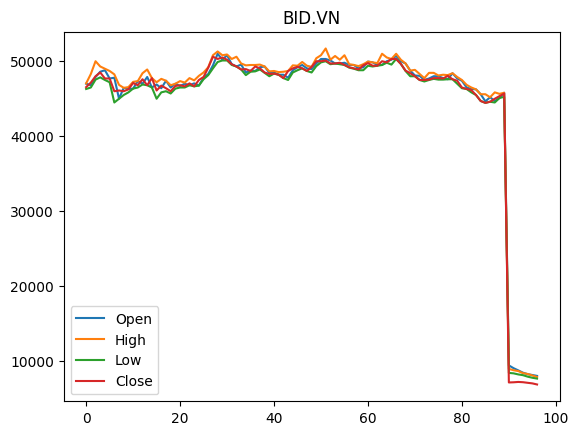

In [51]:
# Predict one company
prediction = predict_one_company(goodCom[1], goodComPath[1], filter_compiled_model[1])
print(prediction[0])
print("Price prediction for latest ", prediction_day, " days :")
prediction[1].plot(title=prediction[0])
plt.show()



In [52]:
def predict_companies(company, companyPath, filtered_companies_model):
    """ Function to predict all good companies. Calling predict_one_company.
    Return: A list of predicted prices from different company."""
    predictions = []
    for i in range(0, len(company)):
        predictions.append(predict_one_company(company[i], companyPath[i], filtered_companies_model[i]))
    return predictions



#Task 3: Decide when to buy, sell, and hold

In [53]:
def decision_making(predictions):
    """Output the list of companies to keep and to sell"""
    portfolio = []
    for company in predictions:
        company_name = company[0]
        company_indicators = company[2]
        company_rsi = company_indicators["rsi"]
        company_rsi = company_rsi.iloc[-prediction_day:]
        buy = []
        sell = []
        hold = []
        index=1
        for i in company_rsi:
          if i<10:
            buy.append(index)
          elif i>80:
            sell.append(index)
          else:
            hold.append(index)
          index+=1
        if len(buy)==0:
          buy=None
        if len(sell)==0:
          sell=None
        if len(hold)==0:
          hold=None
        portfolio.append([company_name, buy, hold, sell])
    return portfolio

In [54]:
# Predict all company & indicators
predictions = predict_companies(goodCom, goodComPath, filter_compiled_model)

In [55]:
# Portfolio management
portfolio = decision_making(predictions)
print("Company name", "Buy date", "Hold date", "Sell date")
for company in portfolio:
    print(company)

Company name Buy date Hold date Sell date
['VCB.VN', [1, 2, 3, 4, 5, 6, 7], None, None]
['BID.VN', [1, 2, 3, 4, 5, 6, 7], None, None]
['CTG.VN', [1, 2, 3, 4, 5, 6, 7], None, None]
['ACB.VN', [1, 2, 3, 4, 5, 6, 7], None, None]
['TCB.VN', [1, 2, 3, 4, 5, 6, 7], None, None]
['SHB.VN', [1, 2, 3, 4, 5, 6, 7], None, None]
['ACB.VN', [1, 2, 3, 4, 5, 6, 7], None, None]
['TPB.VN', [1, 2, 3, 4, 5, 6, 7], None, None]


# Task 4: Create Porfolios for the companies and evaluate


In [56]:
!pip install git+https://github.com/thinh-vu/vnstock.git@main


  Cloning https://github.com/thinh-vu/vnstock.git (to revision main) to /tmp/pip-req-build-o3pudu3z
  Running command git clone --filter=blob:none --quiet https://github.com/thinh-vu/vnstock.git /tmp/pip-req-build-o3pudu3z
  Resolved https://github.com/thinh-vu/vnstock.git to commit 18c03cfc4229beeb28c36fe843b8f74ee0c8865b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for vnstock3: filename=vnstock3-3.1.0-py3-none-any.whl size=93035 sha256=85de7eee147479c6289e0ebb08e66fbd486ed6a2320b0ac24957c491cb5df010
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmsky_eu/wheels/af/d1/dd/4a6968f5e0bb65a0f13b9340b9c6d9e185115f3514f05240ca
Successfully built vnstock3


In [57]:
from vnstock import *

**Vui lòng chuyển đổi sang Vnstock3** thế hệ mới (3.1.0) với câu lệnh: `pip install vnstock3 --upgrade`.
**Từ 1/1/2025, vnstock3 sẽ được cài đặt khi sử dụng cú pháp** `pip install vnstock` **thay cho Vnstock Legacy** hiện tại.
Xem chi tiết [chuyển đổi sang vnstock3](https://vnstocks.com/docs/tai-lieu/migration-chuyen-doi-sang-vnstock3).
Phiên bản **Vnstock Legacy (0.2.9.2.3)** bạn đang sử dụng **sẽ không được nâng cấp thêm.**
Từ 7/10/2024 Vnstock giới thiệu nhóm Facebook Cộng đồng Vnstock, tham gia thảo luận tại đây: https://www.facebook.com/groups/vnstock.official

In [65]:
goodCom

['VCB.VN',
 'BID.VN',
 'CTG.VN',
 'ACB.VN',
 'TCB.VN',
 'SHB.VN',
 'ACB.VN',
 'TPB.VN']

In [67]:
goodCom = [ticker.replace('.VN', '') for ticker in goodCom]
goodCom

['VCB', 'BID', 'CTG', 'ACB', 'TCB', 'SHB', 'ACB', 'TPB']

In [69]:
stock_analysis = pd.DataFrame()

for i in goodCom:
    # Get the stock data for the current company
    temp = general_rating(i)


    # Concatenate to the final stock analysis DataFrame
    stock_analysis = pd.concat([stock_analysis, temp], ignore_index=True)


In [70]:
stock_analysis

,stockRating,valuation,financialHealth,businessModel,businessOperation,rsRating,taScore,ticker,highestPrice,lowestPrice,priceChange3m,priceChange1y,beta,alpha
0,3.1,1.3,3.9,4.7,3.7,3.2,3.0,VCB,97400.0,80300.0,0.035,0.112,0.59,0.0000
1,1.9,2.1,3.4,4.3,3.3,2.2,1.5,BID,54400.0,38850.0,-0.050,0.197,1.08,-0.0004
2,3.1,2.9,3.4,4.5,3.6,3.6,2.5,CTG,37000.0,26050.0,0.016,0.363,1.36,0.0000
3,2.2,3.3,2.9,3.6,4.3,3.3,1.0,ACB,26250.0,18438.0,0.020,0.364,0.89,0.0002
4,2.7,3.3,3.6,3.7,4.3,3.3,2.0,TCB,24900.0,14304.6,0.028,0.653,1.13,0.0014
5,1.5,4.3,1.7,3.0,3.9,2.0,1.0,SHB,11828.8,10100.0,-0.010,-0.004,0.83,-0.0006
6,2.2,3.3,2.9,3.6,4.3,3.3,1.0,ACB,26250.0,18438.0,0.020,0.364,0.89,0.0002
7,1.6,3.3,2.2,3.0,4.1,2.2,1.0,TPB,17900.0,13459.3,0.095,0.168,1.28,0.0002


In [164]:
import pandas as pd

# Define updated criteria for good and bad companies
def classify_company(row):
    # Good company criteria
    is_good = (
        row['stockRating'] >= 3.0 and
        row['valuation'] <= 2.5 and
        row['financialHealth'] >= 3.0 and
        row['businessModel'] >= 3.5 and
        row['taScore'] >= 3.0 and
        row['beta'] <= 1.0 and
        row['alpha'] >= 0
    )

    # Bad company criteria
    is_bad = (
        row['stockRating'] < 2.5 or
        row['valuation'] > 3.5 or
        row['financialHealth'] < 2.5 or
        row['businessModel'] < 3.0 or
        row['taScore'] < 2.0 or
        row['beta'] > 1.5 or
        row['alpha'] < 0
    )

    if is_good:
        return 'Good'
    elif is_bad:
        return 'Bad'
    else:
        return 'Neutral'

# Apply classification to the stock_analysis DataFrame
stock_analysis['portfolio'] = stock_analysis.apply(classify_company, axis=1)

good_companies = stock_analysis[stock_analysis['portfolio'] == 'Good']
bad_companies = stock_analysis[stock_analysis['portfolio'] == 'Bad']

print("Good Companies Portfolio:")
print(good_companies[['ticker', 'stockRating', 'valuation', 'financialHealth', 'businessModel', 'taScore', 'beta', 'alpha']])

print("\nBad Companies Portfolio:")
print(bad_companies[['ticker', 'stockRating', 'valuation', 'financialHealth', 'businessModel', 'taScore', 'beta', 'alpha']])


Good Companies Portfolio:
  ticker  stockRating  valuation  financialHealth  businessModel  taScore  \
0    VCB          3.1        1.3              3.9            4.7      3.0   

   beta  alpha  
0  0.59    0.0  

Bad Companies Portfolio:
  ticker  stockRating  valuation  financialHealth  businessModel  taScore  \
3    ACB          2.2        3.3              2.9            3.6      1.0   
4    ACB          2.2        3.3              2.9            3.6      1.0   
5    BID          1.9        2.1              3.4            4.3      1.5   
6    TPB          1.6        3.3              2.2            3.0      1.0   
7    SHB          1.5        4.3              1.7            3.0      1.0   

   beta   alpha  
3  0.89  0.0002  
4  0.89  0.0002  
5  1.08 -0.0004  
6  1.28  0.0002  
7  0.83 -0.0006  


In [167]:
#more detailed output:
print("\nDetailed Summary for Good Companies:")
for index, row in good_companies.iterrows():
    print(f"Company: {row['ticker']}, Stock Rating: {row['stockRating']}, Business Operation Rating: {row['businessOperation']}")
    print(f"Valuation: {row['valuation']}, Financial Health: {row['financialHealth']}, TA Score: {row['taScore']}\n")

print("\nDetailed Summary for Bad Companies:")
for index, row in bad_companies.iterrows():
    print(f"Company: {row['ticker']}, Stock Rating: {row['stockRating']}, Business Operation Rating: {row['businessOperation']}")
    print(f"Valuation: {row['valuation']}, Financial Health: {row['financialHealth']}, TA Score: {row['taScore']}\n")



Detailed Summary for Good Companies:
Company: VCB, Stock Rating: 3.1, Business Operation Rating: 3.7
Valuation: 1.3, Financial Health: 3.9, TA Score: 3.0


Detailed Summary for Bad Companies:
Company: ACB, Stock Rating: 2.2, Business Operation Rating: 4.3
Valuation: 3.3, Financial Health: 2.9, TA Score: 1.0

Company: ACB, Stock Rating: 2.2, Business Operation Rating: 4.3
Valuation: 3.3, Financial Health: 2.9, TA Score: 1.0

Company: BID, Stock Rating: 1.9, Business Operation Rating: 3.3
Valuation: 2.1, Financial Health: 3.4, TA Score: 1.5

Company: TPB, Stock Rating: 1.6, Business Operation Rating: 4.1
Valuation: 3.3, Financial Health: 2.2, TA Score: 1.0

Company: SHB, Stock Rating: 1.5, Business Operation Rating: 3.9
Valuation: 4.3, Financial Health: 1.7, TA Score: 1.0

